In [36]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
print('Librerias Importadas')

Librerias Importadas


### Modelo SIR

El modelo SIR es uno de los modelos epidemiológicos más simples capaces de capturar muchas de las características típicas de los brotes epidémicos. El nombre del modelo proviene de las iniciales S (población susceptible), I (población infectada) y R (población recuperada). El modelo relaciona las variaciones de las tres poblaciones (Susceptible, Infectada y Recuperada) a través de la tasa de infección y el período infeccioso promedio.


-Población susceptible (S), individuos sin inmunidad al agente infeccioso, y que por tanto puede ser infectada si es expuesta al   agente infeccioso.

-Población infectada (I), individuos que están infectados en un momento dado y pueden transmitir la infección a individuos de la   población susceptible con la que entran en contacto.

-Población recuperada y fallecidos (R), individuos que son inmunes a la infección (o fallecidos), y consecuentemente no afectan   a la transmisión cuando entran en contacto con otros individuos.1​

In [37]:

I0=10
R0=0
S0 = 100000
t = 365
y0 = S0,I0,R0

In [38]:
def confirmados(country,START_DATE):
      df = pd.read_csv('time_series_covid19_confirmed_global.csv')
      country_df = df[df['Country/Region'] == country]
      return country_df.iloc[0].loc[START_DATE:]

In [39]:
def recuperados(country,START_DATE):
      df = pd.read_csv('time_series_covid19_recovered_global.csv')
      country_df = df[df['Country/Region'] == country]
      return country_df.iloc[0].loc[START_DATE:]

In [40]:
data_confirmed=confirmados('Ecuador','5/10/20');
data_recovered=recuperados('Ecuador','5/10/20');

In [41]:
def loss_confirmed_recovered(point, data, recovered):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S0,I0,R0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [42]:
def loss_confirmed(point, data):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S0,I0,R0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

In [43]:
def extend_index(index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

In [44]:
def predict(beta, gamma, data):
        predict_range = t
        new_index = extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [S0,I0,R0], t_eval=np.arange(0, size, 1))

In [45]:
data = data_confirmed
optimal = minimize(
    loss_confirmed,
    [0.001, 0.001],
    args=(data),
    method='L-BFGS-B',
    bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
)
beta, gamma = optimal.x

In [46]:
new_index, extended_actual, prediction = predict(beta, gamma, data)

<AxesSubplot:title={'center':'MODELO SIR ECUADOR'}>

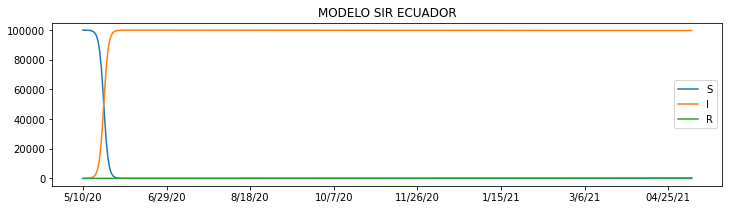

In [47]:
df = pd.DataFrame({
    'S': prediction.y[0],
    'I': prediction.y[1],
    'R': prediction.y[2]
}, index=new_index)
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('MODELO SIR ECUADOR')
df.plot(ax=ax)

        

# Confirmados y Recuperados

In [48]:
dataConfirmed = data_confirmed
dataRecovered = data_recovered
optimal = minimize(
    loss_confirmed_recovered,
    [0.001, 0.001],
    args=(dataConfirmed, dataRecovered),
    method='L-BFGS-B',
    bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
)
betaC, gammaC = optimal.x

In [49]:
new_indexC, extended_actualC, predictionC = predict(betaC, gammaC, dataConfirmed)

<AxesSubplot:title={'center':'MODELO SIR ECUADOR'}>

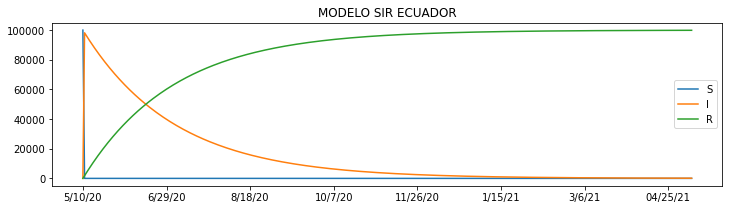

In [51]:
df = pd.DataFrame({
    'S': predictionC.y[0],
    'I': predictionC.y[1],
    'R': predictionC.y[2]
}, index=new_index)
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('MODELO SIR ECUADOR')
df.plot(ax=ax)
